In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

### Feature Engineering

In [2]:
df_financial_data = pd.read_csv('crypto_financial_data.csv', usecols=['Date','Bitcoin','Nasdaq'])
df_financial_data['Date'] = pd.to_datetime(df_financial_data['Date'])
df_financial_data.head()

,Date,Bitcoin,Nasdaq
0,2018-07-01,6366.8,7097.82
1,2018-07-02,6619.5,7097.82
2,2018-07-03,6513.5,7014.55
3,2018-07-04,6598.4,7014.55
4,2018-07-05,6546.5,7101.05


In [3]:
df_btc_statistics = pd.read_csv('bitcoin_statistics.csv')
df_btc_statistics['date_day'] = pd.to_datetime(df_btc_statistics['date_day'], format='%Y/%m/%d')
df_btc_statistics.head()

,date_day,transactions_count,average_transaction_value,average_fee,address_count,Block Reward
0,2023-12-04,570395,1.933717e+08,26340.11,664523,6.25
1,2021-07-26,261950,8.776876e+08,6978.58,603155,6.25
2,2021-07-12,220269,7.613763e+08,13039.09,525192,6.25
3,2023-12-05,514962,1.903891e+08,45962.46,522848,6.25
4,2018-10-11,262467,4.038367e+08,7016.96,484680,12.50


In [4]:
df_btc_statistics = pd.merge(df_financial_data,
                             df_btc_statistics,
                             how='left',
                             left_on='Date',
                             right_on='date_day')
df_btc_statistics = df_btc_statistics.drop(['date_day'], axis=1)
df_btc_statistics.head()

,Date,Bitcoin,Nasdaq,transactions_count,average_transaction_value,average_fee,address_count,Block Reward
0,2018-07-01,6366.8,7097.82,156247,5.490050e+08,10747.66,326089,12.5
1,2018-07-02,6619.5,7097.82,199294,5.002205e+08,11781.91,444107,12.5
2,2018-07-03,6513.5,7014.55,216747,4.898527e+08,12873.35,452632,12.5
3,2018-07-04,6598.4,7014.55,206788,4.298247e+08,10418.66,407761,12.5
4,2018-07-05,6546.5,7101.05,199600,5.167851e+08,9902.81,359493,12.5


In [5]:
# Convert Transaction Value and Fee from Satoshis to Bitcoin
df_btc_statistics['average_transaction_value_btc'] = df_btc_statistics['average_transaction_value'] / 100000000
df_btc_statistics['average_fee_btc'] = df_btc_statistics['average_fee'] / 100000000
df_btc_statistics = df_btc_statistics.drop(['average_fee','average_transaction_value'], axis=1)

In [6]:
# Replace Outlier
df_btc_statistics.loc[df_btc_statistics['average_transaction_value_btc'] > 70,'average_transaction_value_btc'] = df_btc_statistics['average_transaction_value_btc'].mean()

In [7]:
# Create Daily Netwrok Volume Variable - Transactions * Average Transaction Value
df_btc_statistics['daily_volume'] = df_btc_statistics['average_transaction_value_btc'] * df_btc_statistics['transactions_count']

In [8]:
# Smooth variables with 7 day rolling average
df_btc_statistics['address_count_week_avg'] = df_btc_statistics['address_count'].rolling(7).mean()
df_btc_statistics['transaction_count_week_avg'] = df_btc_statistics['transactions_count'].rolling(7).mean()
df_btc_statistics['daily_volume_week_avg'] = df_btc_statistics['daily_volume'].rolling(7).mean()

df_btc_statistics['address_count_week_avg'] = df_btc_statistics['address_count_week_avg'].fillna(method='bfill')
df_btc_statistics['transaction_count_week_avg'] = df_btc_statistics['transaction_count_week_avg'].fillna(method='bfill')
df_btc_statistics['daily_volume_week_avg'] = df_btc_statistics['daily_volume_week_avg'].fillna(method='bfill')

In [9]:
df_btc_statistics.head()

,Date,Bitcoin,Nasdaq,transactions_count,address_count,Block Reward,average_transaction_value_btc,average_fee_btc,daily_volume,address_count_week_avg,transaction_count_week_avg,daily_volume_week_avg
0,2018-07-01,6366.8,7097.82,156247,326089,12.5,5.490050,0.000107,8.578038e+05,380300.714286,192832.714286,916162.35428
1,2018-07-02,6619.5,7097.82,199294,444107,12.5,5.002205,0.000118,9.969094e+05,380300.714286,192832.714286,916162.35428
2,2018-07-03,6513.5,7014.55,216747,452632,12.5,4.898527,0.000129,1.061741e+06,380300.714286,192832.714286,916162.35428
3,2018-07-04,6598.4,7014.55,206788,407761,12.5,4.298247,0.000104,8.888260e+05,380300.714286,192832.714286,916162.35428
4,2018-07-05,6546.5,7101.05,199600,359493,12.5,5.167851,0.000099,1.031503e+06,380300.714286,192832.714286,916162.35428


<AxesSubplot:>

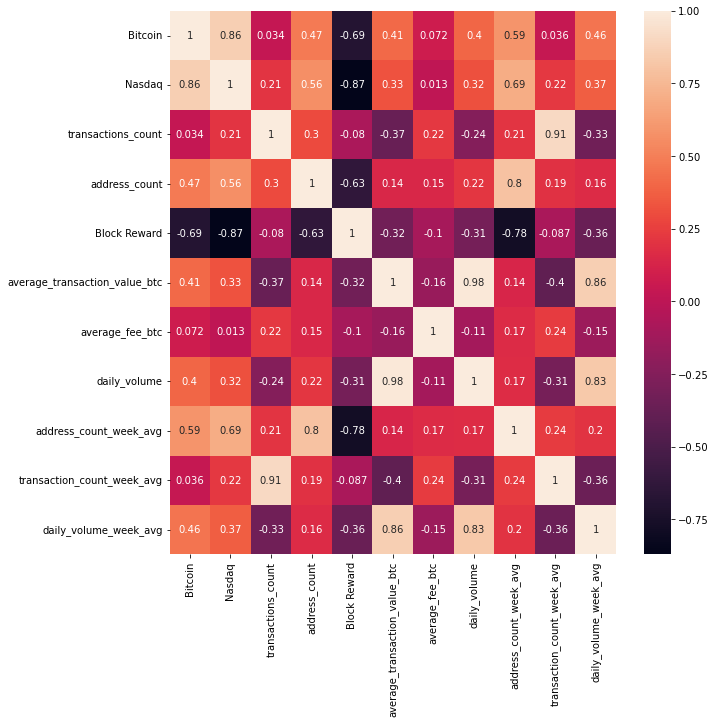

In [10]:
# Highest Correlation: Nasdaq, address_count_week_avg, average_transaction_value, daily_volume_week_avg
# Correlation Plot
plt.figure(figsize=(10,10))
sns.heatmap(df_btc_statistics.corr(), annot=True)

### Linear Regression

In [11]:
# Training 1/7/2018 to 30/6/2023
# Testing 1/7/2023 to 31/12/23
df_btc_train = df_btc_statistics[df_btc_statistics['Date'] <= '2023-06-30']
df_btc_test = df_btc_statistics[df_btc_statistics['Date'] > '2023-06-30']
df_btc_train = df_btc_train.fillna(method='bfill')

In [12]:
print(df_btc_train.shape)
print(df_btc_test.shape)

(1826, 12)
(184, 12)


In [13]:
def training_test_split(col):
    x_train = df_btc_train[col].values.reshape(-1,1)
    x_test = df_btc_test[col].values.reshape(-1,1)
   
    return x_train, x_test

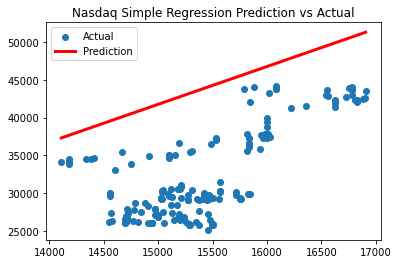

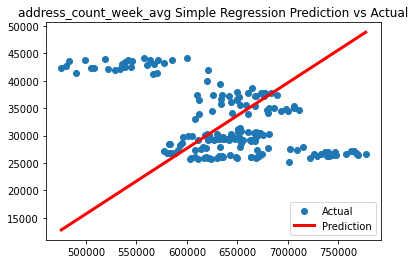

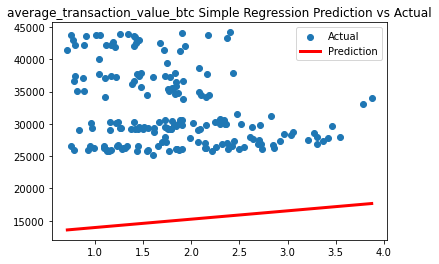

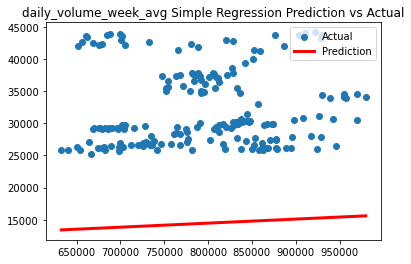

In [14]:
# Simple Linear Regression with Key Variables
# Highest Correlation: Nasdaq, address_count_week_avg, average_transaction_value, daily_volume_week_avg

y_train = df_btc_train['Bitcoin'].values.reshape(-1,1)
y_test = df_btc_test['Bitcoin'].values.reshape(-1,1)
results_dict = {'target': pd.Series(y_test.reshape(184,))}

for column in ['Nasdaq', 'address_count_week_avg','average_transaction_value_btc', 'daily_volume_week_avg']:
    
    x_train, x_test = training_test_split(column)
    
    reg = linear_model.LinearRegression()
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    
    ref_str = f'{column}_predictions'
    results_dict[column] = pd.Series(y_pred.reshape(184,))
    
    prediction_space = np.linspace(min(x_test),max(x_test)).reshape(-1,1)
    plt.scatter(x_test, y_test, label='Actual')
    plt.plot(prediction_space, reg.predict(prediction_space), color='red',linewidth=3, label='Prediction')
    plt.title(f'{column} Simple Regression Prediction vs Actual')
    plt.legend()
    plt.show()

<Figure size 1440x720 with 0 Axes>

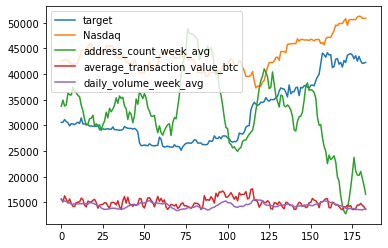

In [15]:
# Combine Predictions in Dataframe
results_df = pd.DataFrame.from_dict(results_dict, orient='columns')

# Plot Predictions 
plt.figure(figsize=(20,10))
results_df.plot()
plt.show()

In [16]:
# RMSE score for each Simple Regression Model
for column in ['Nasdaq', 'address_count_week_avg','average_transaction_value_btc', 'daily_volume_week_avg']:
    rmse_stat = mean_squared_error(results_df['target'], results_df[column], squared=False)
    print(f'{column}: {rmse_stat}')

Nasdaq: 12326.347008552219
address_count_week_avg: 11608.579851610628
average_transaction_value_btc: 18283.469631665645
daily_volume_week_avg: 18695.658805841973


In [17]:
# Multiple Linear Regression
drop_cols = ['transactions_count','address_count', 'average_fee_btc','Date',
             'daily_volume','transaction_count_week_avg','daily_volume_week_avg','Block Reward']

# Drop less correlated columns, keep high correlated non-colinear columns
df_btc_all_train = df_btc_train.drop(drop_cols, axis=1)
df_btc_all_test = df_btc_test.drop(drop_cols, axis=1)

In [18]:
# Convert to train and test sets
y_train = df_btc_all_train['Bitcoin'].values
y_train = y_train.reshape(-1,1)
y_test = df_btc_all_test['Bitcoin'].values
y_test = y_test.reshape(-1,1)

x_train = df_btc_all_train.drop(['Bitcoin'], axis=1).values
x_test = df_btc_all_test.drop(['Bitcoin'], axis=1).values

In [19]:
# Multiple linear regression
reg_all = linear_model.LinearRegression()
reg_all.fit(x_train, y_train)
y_pred = reg_all.predict(x_test)

print(mean_squared_error(df_btc_all_test['Bitcoin'],pd.Series(y_pred.reshape(184,)) , squared=False))
results_df['MR_1'] = pd.Series(y_pred.reshape(184,))

10653.750412833497


In [20]:
results_df['Date'] = pd.to_datetime(df_btc_test['Date'].reset_index(drop=True), format='%Y-%m-%d')

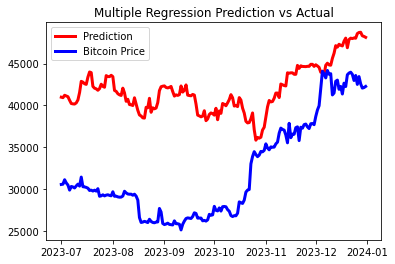

In [21]:
plt.plot(results_df['Date'], results_df['MR_1'], color='red',linewidth=3, label='Prediction')
plt.plot(results_df['Date'], results_df['target'], color='blue',linewidth=3, label='Bitcoin Price')
plt.title('Multiple Regression Prediction vs Actual')
plt.legend()
plt.show()

In [22]:
# Remove columns that have been altered, Date and Target columns
x = df_btc_train.drop(['Bitcoin','transactions_count','address_count', 'average_fee_btc','Date',
             'daily_volume','transaction_count_week_avg'], axis=1).values

y = df_btc_train['Bitcoin'].values

names = df_btc_train.drop(['Bitcoin','transactions_count','address_count', 'average_fee_btc','Date',
             'daily_volume','transaction_count_week_avg'], axis=1).columns

# Calculate the Lasso coefficient for the variables
lasso = Lasso(alpha=1.0)
lasso_coef = lasso.fit(x,y).coef_

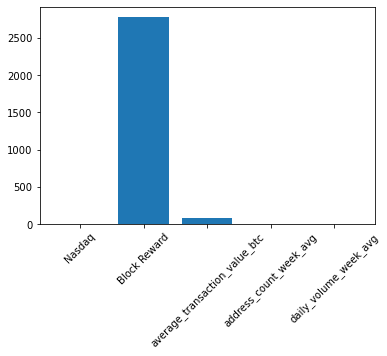

In [23]:
plt.bar(names, lasso_coef)
plt.xticks(rotation=45)
plt.show()

In [24]:
df_btc_train

,Date,Bitcoin,Nasdaq,transactions_count,address_count,Block Reward,average_transaction_value_btc,average_fee_btc,daily_volume,address_count_week_avg,transaction_count_week_avg,daily_volume_week_avg
0,2018-07-01,6366.8,7097.82,156247,326089,12.50,5.490050,0.000107,8.578038e+05,380300.714286,192832.714286,9.161624e+05
1,2018-07-02,6619.5,7097.82,199294,444107,12.50,5.002205,0.000118,9.969094e+05,380300.714286,192832.714286,9.161624e+05
2,2018-07-03,6513.5,7014.55,216747,452632,12.50,4.898527,0.000129,1.061741e+06,380300.714286,192832.714286,9.161624e+05
3,2018-07-04,6598.4,7014.55,206788,407761,12.50,4.298247,0.000104,8.888260e+05,380300.714286,192832.714286,9.161624e+05
4,2018-07-05,6546.5,7101.05,199600,359493,12.50,5.167851,0.000099,1.031503e+06,380300.714286,192832.714286,9.161624e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2023-06-26,30267.0,14689.02,403979,706002,6.25,2.578435,0.000080,1.041634e+06,660014.142857,389317.428571,1.008440e+06
1822,2023-06-27,30689.1,14945.91,434858,643443,6.25,2.275311,0.000073,9.894371e+05,660462.285714,387480.714286,9.982970e+05
1823,2023-06-28,30078.6,14964.58,331278,514654,6.25,2.811753,0.000090,9.314719e+05,652277.142857,382909.000000,9.572636e+05
1824,2023-06-29,30445.7,14939.95,438193,659176,6.25,2.603426,0.000085,1.140803e+06,648497.000000,389502.142857,9.523869e+05


In [25]:
# Key variables were Block Reward, Average_transaction_value and Nasdaq
df_btc_lasso_train = df_btc_train[['Bitcoin','Nasdaq','Block Reward','average_transaction_value_btc']]
df_btc_lasso_test = df_btc_test[['Bitcoin','Nasdaq','Block Reward','average_transaction_value_btc']]


In [26]:
y_train = df_btc_lasso_train['Bitcoin'].values
y_train = y_train.reshape(-1,1)
y_test = df_btc_lasso_test['Bitcoin'].values
y_test = y_test.reshape(-1,1)

x_train = df_btc_lasso_train.drop(['Bitcoin'], axis=1).values
x_test = df_btc_lasso_test.drop(['Bitcoin'], axis=1).values

In [27]:
reg_all = linear_model.LinearRegression()
reg_all.fit(x_train, y_train)
y_pred = reg_all.predict(x_test)

print(mean_squared_error(df_btc_lasso_test['Bitcoin'], pd.Series(y_pred.reshape(184,)),squared=False))

results_df['MR_lasso'] = pd.Series(y_pred.reshape(184,))

13996.835058826913


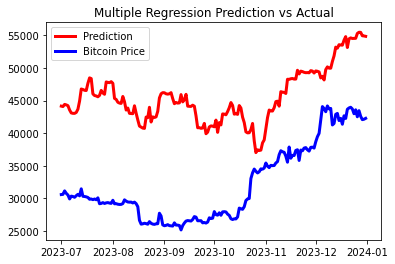

In [28]:
plt.plot(results_df['Date'], results_df['MR_lasso'], color='red',linewidth=3, label='Prediction')
plt.plot(results_df['Date'], results_df['target'], color='blue',linewidth=3, label='Bitcoin Price')
plt.title('Multiple Regression Prediction vs Actual')
plt.legend()
plt.show()